In [8]:
#DOWNLOAD DATASET
import gdown
url = 'https://drive.google.com/uc?id=1bqcZUqVe5Ln7W56DlVZs4PH16hPFZiSq'
output = 'miniecoset_data'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bqcZUqVe5Ln7W56DlVZs4PH16hPFZiSq
To: /content/miniecoset_data
100%|██████████| 3.32G/3.32G [00:33<00:00, 100MB/s]


'miniecoset_data'

In [9]:
#Install necessary packages
!pip install h5py torch torchvision

In [10]:
#Mount your google drive to access downloaded dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#Necessary imports
import h5py
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [14]:
## Load the full MiniEcoset HDF5 file into a nested dictionary
def h5_to_dict(h5file):
    """Convert HDF5 group to nested dictionary."""
    result = {}
    for key, item in h5file.items():
        if isinstance(item, h5py.Dataset):  # Check if it's a dataset
            result[key] = item[()]
        elif isinstance(item, h5py.Group):  # Check if it's a group
            result[key] = h5_to_dict(item)
    return result

#filename = '/content/drive/MyDrive/miniecoset_64px.h5' #Can adjust and uncomment if storing data in another place
filename = '/content/miniecoset_data'

with h5py.File(filename, 'r') as f:
    data_dict = h5_to_dict(f)

#print(data_dict)

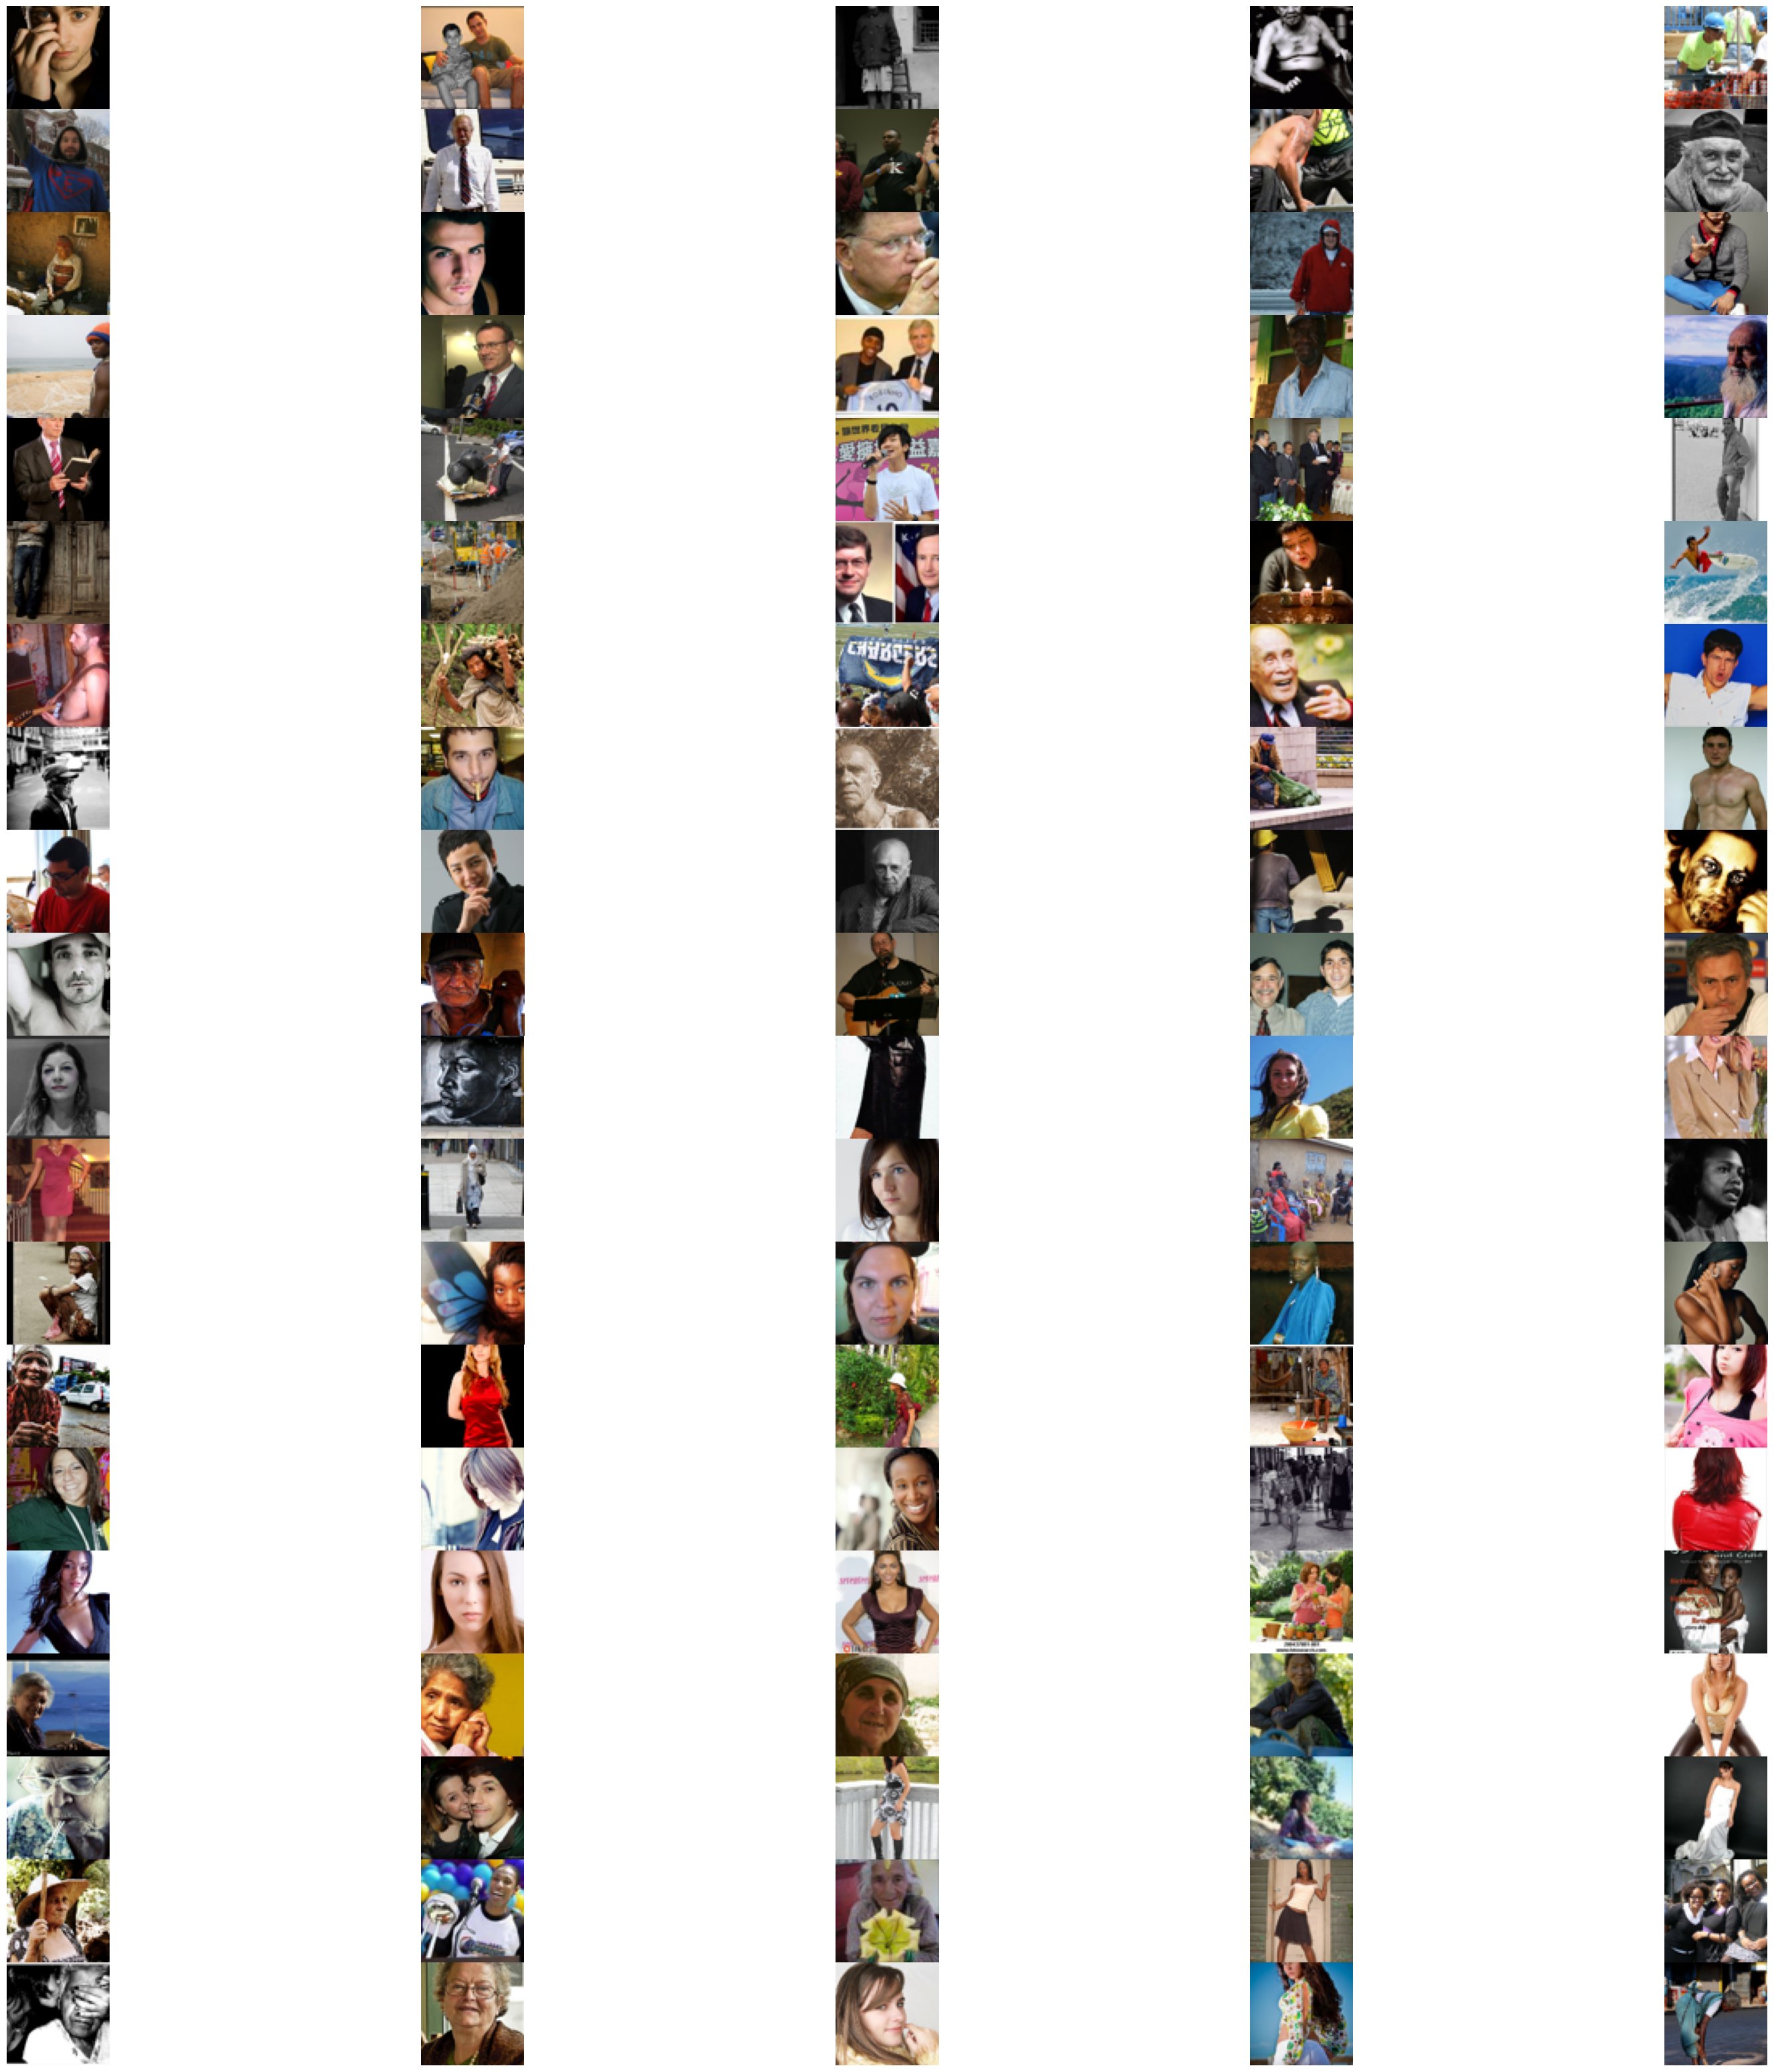

In [15]:
#PRINT IMAGES
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#Accessing the images in the 'val' dataset
image_data = data_dict['val']['data']

#'image_data' is a numpy array with shape (num_images, 64, 64, 3)
num_images = image_data.shape[0]

# Define the number of rows and columns for the grid
num_rows = 20  # Adjust the number of rows as needed, currently printing the 'men' and 'women'
num_cols = 5  # Adjust the number of columns as needed

# Create a grid of subplots to display the images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40))

# Iterate through the images and display them in subplots
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < num_images:
            image = image_data[index]
            axes[i, j].imshow(image)
            axes[i, j].axis('off')  # Hide axis labels and ticks

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Show the grid of images
plt.show()


### Finetune ResNet50 on MiniEcoset using PyTorch

In [ ]:
##**Step 1: Prepare the Data Loaders*

In [ ]:
class MiniEcosetDataset(Dataset):
    def __init__(self, hdf5_file, subset, transform=None):
        self.hdf5_file = hdf5_file
        self.subset = subset  # this should be 'train', 'val', 'test', etc.
        self.transform = transform

        with h5py.File(hdf5_file, 'r') as file:
          self.length = len(file[f'{self.subset}/data'])  # access the data using the subset

        # Load labels from the "train" group
          self.labels = file[f'{self.subset}/labels']


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as file:
            # Access the data and labels using the subset
            image = file[f'{self.subset}/data'][idx]
            label = file[f'{self.subset}/labels'][idx]

        # Convert image from numpy array to torch tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # CxHxW format

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing according to ResNet50 requirements
])

# Create dataset
train_dataset = MiniEcosetDataset(hdf5_file='/content/miniecoset_data', subset='train', transform=transform)
val_dataset = MiniEcosetDataset(hdf5_file='/content/miniecoset_data', subset='val', transform=transform) #test on 'val' set; can also use 'train'

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
##*Step 2: Load a Pretrained ResNet50 and Modify the Last Layer**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze the weights of the pre-existing layers:
for param in model.parameters():
    param.requires_grad = False

# Now, you should replace the last layer with a new layer that has the same input dimension,
# but the output dimension should be the number of classes in your dataset.

num_classes = 100

# ResNet models have their fully connected layer at 'fc',
# we'll replace it with a new one with the appropriate number of outputs
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Now the model is ready, and can train it on your dataset.


In [ ]:
##*Step 3: Train the Model if Fine-tuning**

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Dataset is named 'train_dataset' and 'val_dataset'
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function
criterion = torch.nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can change the learning rate

# Define the number of epochs
epochs = 10  # You can change the number of epochs

# Move the model to the GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        labels = labels.long()  # Convert labels to LongTensor

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # In the validation phase, we don't need to compute gradients
        for images, labels in val_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            labels = labels.long()  # Convert labels to LongTensor

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 2.6796
Validation Loss: 2.5135, Accuracy: 44.72%


### Visualize the activations from the ResNet50 model's feature layer


In [ ]:
##*1. Modify ResNet50 to Return the 2048 Neuron Activations:**
##To modify ResNet50 to return the activations, we remove the last fully connected layer.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        # Load the pretrained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)
        # Remove the last fully connected layer (layer4)
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward(self, x):
        # Forward pass, get the feature vector before the final fully connected layer
        x = self.features(x)
        # If you're not removing the AvgPool, you'll end up with a 4D tensor
        # Modify the shape to be more manageable
        x = x.view(x.size(0), -1)
        return x

# Now create the model
model = ResNet50FeatureExtractor()

# Example of passing a dummy input through the model
# Remember, input size for ResNet50 should be at least 224x224
with torch.no_grad():  # No need to track the gradients
    dummy_input = torch.randn(1, 3, 224, 224)  # Dummy input
    features = model(dummy_input)  # Extract features
    print(features.shape)  # Should show the feature vector shape, e.g., [1, 2048]


In [ ]:
##**2. Extract and Save Activations:*

In [ ]:
#Check of train_loader file, can ignore
len(train_loader)
_ = next(iter(train_loader))
len(_)
_[0].shape, _[1].shape

In [ ]:
#Evaluate activations from model
import numpy as np
import torch

# Assuming train_loader is your DataLoader containing the dataset

model.eval()  # Set the model to evaluation mode
activations = []

with torch.no_grad():  # No need to track the gradients
    for batch in val_loader: # can use test_loader here as well; need to computer earlier
        images, _ = batch  # Get the images from the batch; ignore labels
        features = model(images)  # Pass the batch through the model to get the activations
        activations.append(features.cpu().numpy())  # Save the activations

# Concatenate all the activations retrieved
activations = np.concatenate(activations, axis=0)


In [ ]:
# Save with numpy
np.save('activations.npy', activations)

In [ ]:
##**3. Apply PCA to Reduce Dimensionality:**

In [ ]:
#Install necessary packages
!pip install scikit-learn

In [ ]:
from sklearn.decomposition import PCA

# Load activations
activations = np.load('activations.npy')

# Initialize PCA; you can specify the number of components: PCA(n_components=50)for the 50 principal components.
# If not specified, all components are kept; currently all are kept fo elbow plot
pca = PCA()

# Fit PCA on your data and transform it
principal_components = pca.fit_transform(activations)

# Now, principal_components are your activations in the reduced-dimensional space


In [ ]:
# Save the reduced data
np.save('reduced_activations.npy', principal_components)

In [ ]:
##**4. Visualize the 2D Representations:**

In [ ]:
#ELBOW PLOT
import matplotlib.pyplot as plt

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure()
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Component-wise and Cumulative Explained Variance')
plt.show()


In [ ]:
#CHANGE NUMBER OF PCA COMPONENTS AND RE-RUN AFTER ELBOW PLOT

In [ ]:
#2D PCA
component_labels = data_dict['val']['labels']
# Visualize the data in the PCA space
colormap = plt.cm.get_cmap('viridis', len(np.unique(component_labels)))

# Scatter plot with colors based on components
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=component_labels, cmap=colormap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.legend()
plt.colorbar()
plt.show()


In [ ]:
#3D PCA
# Compute component labels (you can replace this with your actual labels)
component_labels = data_dict['val']['labels']

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on components
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=component_labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA in 3D with Colors')

# Create a colorbar to indicate the mapping of labels to colors
cbar = plt.colorbar(scatter, label='Component Labels')